In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

import talos

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

In [2]:
# Fetch data and split into training-validation set and test set
mnist = fetch_openml("mnist_784", version = 1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int8) # converting target to numbers instead of character
X_prevalidsplit, X_test, y_prevalidsplit, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [3]:
# Split set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_prevalidsplit, y_prevalidsplit, random_state=42, test_size=0.2)

In [4]:
# Standardize Xs
scaler = StandardScaler()
X_train_tr = scaler.fit_transform(X_train)
X_valid_tr = scaler.transform(X_valid)
X_test_tr = scaler.transform(X_test)

# convert targets to one-hot vertors
y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

Define neural network model as object to use for hyperparameters tunning (N of hidden layers, N of neurons within layer, regularization, batch size)

In [16]:
# helper function for tensorboard callback
root_logdir = os.path.join(os.curdir, "/Users/szymonmizak/machine_learning/mnist_project", "my_logs")
def get_run_logdir(): 
  run_id = time.strftime("run_%Y_%m%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)

In [17]:
# define callback to use in model function
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)

# define model generation function
def mnist_dense_model(x_tr, y_tr, x_val, y_val, params):
    # build model architecture
    model = Sequential()
    model.add(Input(shape=x_tr.shape[1])) 
    
    for l in params['hidden_layers']:
        model.add(tf.keras.layers.Dense(l, activation=params['activation']))
        if params['batch_normalization'] == True:
            model.add(BatchNormalization())

    model.add(Dropout(params['dropout_rate']))
    model.add(
        Dense(10, activation=params['last_activation'])
        ) 

    # compile model
    model.compile(optimizer = params['optimizer'](learning_rate = params['lr']), 
                  loss = params['losses'], 
                  metrics=['accuracy']) 
    # fit model
    history = model.fit(x_tr, y_tr, 
                        validation_data = [x_val, y_val], 
                        batch_size = params['batch_size'], 
                        callbacks = [early_stopping_cb, tf.keras.callbacks.TensorBoard(get_run_logdir())], 
                        epochs = params['epochs'],
                        verbose = 0
                        )
    return history, model

# Define hyperparameters grid
params_space = {
    'lr': [0.0001, 0.0003, 0.001, 0.003],
    'hidden_layers': [(256, 256), (256, 256, 256), (256, 256, 256, 256), 
                      (512, 512), (512, 512, 512), (512, 512, 512, 512)], 
    'shapes': ['brick'],     
    'batch_size': [8, 16, 32], 
    'epochs': [100], 
    'optimizer': [Adam], 
    'losses': ['categorical_crossentropy'], 
    'activation': ['relu'], 
    'last_activation': ['softmax'], 
    'dropout_rate': [0, .1, .2], 
    'batch_normalization': [True, False]
}

In [18]:
# Run hyperparameters space scan using random search
scan_object = talos.Scan(X_train_tr, 
                         y_train, 
                         params_space, 
                         mnist_dense_model, 
                         "mnist", 
                         X_valid_tr, 
                         y_valid, 
                         print_params=True, 
                         fraction_limit=0.2)

  0%|                                                    | 0/86 [00:00<?, ?it/s]2022-06-24 19:44:54.104160: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


{'lr': 0.001, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


  1%|▍                                        | 1/86 [01:58<2:47:30, 118.24s/it]

{'lr': 0.0001, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


  2%|▉                                        | 2/86 [03:33<2:26:18, 104.50s/it]

{'lr': 0.001, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': False}


  3%|█▍                                       | 3/86 [06:28<3:09:06, 136.70s/it]

{'lr': 0.003, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': True}


  5%|█▉                                       | 4/86 [13:51<5:52:20, 257.81s/it]

{'lr': 0.001, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': True}


  6%|██▍                                      | 5/86 [15:08<4:19:52, 192.50s/it]

{'lr': 0.0003, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


  7%|██▊                                      | 6/86 [15:53<3:09:41, 142.27s/it]

{'lr': 0.003, 'hidden_layers': (512, 512, 512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': False}


  8%|███▎                                     | 7/86 [18:27<3:12:27, 146.17s/it]

{'lr': 0.003, 'hidden_layers': (512, 512, 512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


  9%|███▊                                     | 8/86 [21:50<3:33:42, 164.39s/it]

{'lr': 0.003, 'hidden_layers': (512, 512, 512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 10%|████▎                                    | 9/86 [23:58<3:16:23, 153.04s/it]

{'lr': 0.0001, 'hidden_layers': (256, 256), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 12%|████▋                                   | 10/86 [26:21<3:09:56, 149.95s/it]

{'lr': 0.001, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 13%|█████                                   | 11/86 [27:14<2:30:23, 120.32s/it]

{'lr': 0.003, 'hidden_layers': (256, 256), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': False}


 14%|█████▌                                  | 12/86 [28:43<2:16:24, 110.61s/it]

{'lr': 0.003, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 15%|██████                                  | 13/86 [32:13<2:51:05, 140.62s/it]

{'lr': 0.0003, 'hidden_layers': (256, 256), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 16%|██████▌                                 | 14/86 [33:41<2:29:45, 124.80s/it]

{'lr': 0.0001, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


 17%|██████▉                                 | 15/86 [35:52<2:30:06, 126.85s/it]

{'lr': 0.0003, 'hidden_layers': (512, 512, 512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 19%|███████▍                                | 16/86 [42:21<3:59:46, 205.52s/it]

{'lr': 0.0003, 'hidden_layers': (256, 256), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 20%|███████▉                                | 17/86 [45:13<3:44:52, 195.54s/it]

{'lr': 0.0003, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 21%|████████▎                               | 18/86 [49:59<4:12:36, 222.88s/it]

{'lr': 0.003, 'hidden_layers': (512, 512, 512, 512), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 22%|████████▊                               | 19/86 [53:03<3:55:51, 211.22s/it]

{'lr': 0.0001, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 23%|█████████▎                              | 20/86 [59:33<4:51:23, 264.89s/it]

{'lr': 0.003, 'hidden_layers': (256, 256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 24%|█████████▎                            | 21/86 [1:00:35<3:40:46, 203.79s/it]

{'lr': 0.001, 'hidden_layers': (256, 256, 256, 256), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 26%|█████████▋                            | 22/86 [1:02:37<3:11:13, 179.28s/it]

{'lr': 0.001, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 27%|██████████▏                           | 23/86 [1:03:37<2:30:43, 143.55s/it]

{'lr': 0.003, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


 28%|██████████▌                           | 24/86 [1:08:16<3:10:11, 184.06s/it]

{'lr': 0.0001, 'hidden_layers': (256, 256), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 29%|███████████                           | 25/86 [1:09:34<2:34:46, 152.24s/it]

{'lr': 0.001, 'hidden_layers': (256, 256), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


 30%|███████████▍                          | 26/86 [1:11:46<2:26:24, 146.41s/it]

{'lr': 0.003, 'hidden_layers': (256, 256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': True}


 31%|███████████▉                          | 27/86 [1:13:44<2:15:31, 137.82s/it]

{'lr': 0.0003, 'hidden_layers': (256, 256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': False}


 33%|████████████▎                         | 28/86 [1:14:43<1:50:12, 114.00s/it]

{'lr': 0.001, 'hidden_layers': (512, 512, 512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 34%|████████████▊                         | 29/86 [1:19:20<2:34:52, 163.03s/it]

{'lr': 0.0001, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 35%|█████████████▎                        | 30/86 [1:21:48<2:27:49, 158.39s/it]

{'lr': 0.001, 'hidden_layers': (512, 512, 512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 36%|█████████████▋                        | 31/86 [1:23:55<2:16:45, 149.18s/it]

{'lr': 0.0003, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 37%|██████████████▏                       | 32/86 [1:26:16<2:12:02, 146.72s/it]

{'lr': 0.003, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': False}


 38%|██████████████▌                       | 33/86 [1:30:06<2:31:35, 171.61s/it]

{'lr': 0.001, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': True}


 40%|███████████████                       | 34/86 [1:31:51<2:11:31, 151.75s/it]

{'lr': 0.001, 'hidden_layers': (512, 512, 512, 512), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': False}


 41%|███████████████▍                      | 35/86 [1:36:15<2:37:30, 185.30s/it]

{'lr': 0.0001, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


 42%|███████████████▉                      | 36/86 [1:42:48<3:26:14, 247.49s/it]

{'lr': 0.0003, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 43%|████████████████▎                     | 37/86 [1:47:19<3:27:54, 254.59s/it]

{'lr': 0.0001, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': False}


 44%|████████████████▊                     | 38/86 [1:49:38<2:56:00, 220.01s/it]

{'lr': 0.003, 'hidden_layers': (256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 45%|█████████████████▏                    | 39/86 [1:51:04<2:20:51, 179.82s/it]

{'lr': 0.001, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 47%|█████████████████▋                    | 40/86 [1:54:28<2:23:27, 187.11s/it]

{'lr': 0.0001, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': False}


 48%|██████████████████                    | 41/86 [1:55:25<1:51:05, 148.11s/it]

{'lr': 0.001, 'hidden_layers': (512, 512, 512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 49%|██████████████████▌                   | 42/86 [2:02:39<2:51:28, 233.83s/it]

{'lr': 0.003, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 50%|███████████████████                   | 43/86 [2:07:54<3:04:59, 258.13s/it]

{'lr': 0.001, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 51%|███████████████████▍                  | 44/86 [2:09:16<2:23:39, 205.24s/it]

{'lr': 0.0003, 'hidden_layers': (256, 256, 256, 256), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 52%|███████████████████▉                  | 45/86 [2:12:48<2:21:42, 207.37s/it]

{'lr': 0.003, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


 53%|████████████████████▎                 | 46/86 [2:16:31<2:21:15, 211.89s/it]

{'lr': 0.003, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 55%|████████████████████▊                 | 47/86 [2:18:18<1:57:19, 180.51s/it]

{'lr': 0.003, 'hidden_layers': (256, 256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 56%|█████████████████████▏                | 48/86 [2:19:40<1:35:34, 150.90s/it]

{'lr': 0.001, 'hidden_layers': (512, 512, 512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': True}


 57%|█████████████████████▋                | 49/86 [2:27:28<2:31:42, 246.00s/it]

{'lr': 0.003, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 58%|██████████████████████                | 50/86 [2:32:18<2:35:32, 259.25s/it]

{'lr': 0.003, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 59%|██████████████████████▌               | 51/86 [2:35:25<2:18:35, 237.59s/it]

{'lr': 0.001, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


 60%|██████████████████████▉               | 52/86 [2:38:36<2:06:47, 223.76s/it]

{'lr': 0.003, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': False}


 62%|███████████████████████▍              | 53/86 [2:40:14<1:42:11, 185.82s/it]

{'lr': 0.001, 'hidden_layers': (256, 256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 63%|███████████████████████▊              | 54/86 [2:41:38<1:22:53, 155.41s/it]

{'lr': 0.0003, 'hidden_layers': (256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


 64%|████████████████████████▎             | 55/86 [2:42:45<1:06:33, 128.84s/it]

{'lr': 0.003, 'hidden_layers': (256, 256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 65%|██████████████████████████              | 56/86 [2:44:14<58:31, 117.04s/it]

{'lr': 0.0001, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 66%|█████████████████████████▏            | 57/86 [2:48:01<1:12:30, 150.03s/it]

{'lr': 0.0003, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 67%|█████████████████████████▋            | 58/86 [2:54:52<1:46:30, 228.24s/it]

{'lr': 0.0001, 'hidden_layers': (256, 256), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': True}


 69%|██████████████████████████            | 59/86 [2:56:36<1:25:55, 190.93s/it]

{'lr': 0.001, 'hidden_layers': (256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': True}


 70%|██████████████████████████▌           | 60/86 [2:57:34<1:05:28, 151.11s/it]

{'lr': 0.003, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 71%|████████████████████████████▎           | 61/86 [2:58:57<54:23, 130.52s/it]

{'lr': 0.001, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 72%|███████████████████████████▍          | 62/86 [3:02:25<1:01:34, 153.94s/it]

{'lr': 0.001, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': True}


 73%|█████████████████████████████▎          | 63/86 [3:05:03<59:24, 154.97s/it]

{'lr': 0.0003, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 74%|█████████████████████████████▊          | 64/86 [3:06:39<50:21, 137.34s/it]

{'lr': 0.001, 'hidden_layers': (256, 256, 256, 256), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': True}


 76%|██████████████████████████████▏         | 65/86 [3:09:33<51:54, 148.31s/it]

{'lr': 0.0003, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


 77%|██████████████████████████████▋         | 66/86 [3:11:24<45:45, 137.29s/it]

{'lr': 0.0003, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 78%|███████████████████████████████▏        | 67/86 [3:13:14<40:53, 129.11s/it]

{'lr': 0.003, 'hidden_layers': (256, 256, 256, 256), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 79%|███████████████████████████████▋        | 68/86 [3:14:35<34:20, 114.49s/it]

{'lr': 0.0003, 'hidden_layers': (256, 256, 256), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


 80%|████████████████████████████████        | 69/86 [3:18:01<40:11, 141.87s/it]

{'lr': 0.0001, 'hidden_layers': (256, 256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


 81%|████████████████████████████████▌       | 70/86 [3:19:44<34:44, 130.31s/it]

{'lr': 0.001, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': False}


 83%|█████████████████████████████████       | 71/86 [3:23:40<40:30, 162.02s/it]

{'lr': 0.0001, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': False}


 84%|█████████████████████████████████▍      | 72/86 [3:25:36<34:33, 148.12s/it]

{'lr': 0.0003, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


 85%|█████████████████████████████████▉      | 73/86 [3:29:10<36:22, 167.91s/it]

{'lr': 0.0003, 'hidden_layers': (256, 256), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': True}


 86%|██████████████████████████████████▍     | 74/86 [3:33:05<37:38, 188.24s/it]

{'lr': 0.001, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 87%|██████████████████████████████████▉     | 75/86 [3:34:52<30:02, 163.91s/it]

{'lr': 0.003, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 88%|███████████████████████████████████▎    | 76/86 [3:40:04<34:42, 208.30s/it]

{'lr': 0.0001, 'hidden_layers': (256, 256, 256, 256), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 90%|███████████████████████████████████▊    | 77/86 [3:41:39<26:08, 174.28s/it]

{'lr': 0.003, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


 91%|████████████████████████████████████▎   | 78/86 [3:46:54<28:50, 216.35s/it]

{'lr': 0.003, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 92%|████████████████████████████████████▋   | 79/86 [3:48:26<20:53, 179.02s/it]

{'lr': 0.0003, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 93%|█████████████████████████████████████▏  | 80/86 [3:51:53<18:45, 187.55s/it]

{'lr': 0.0003, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': True}


 94%|█████████████████████████████████████▋  | 81/86 [3:54:01<14:08, 169.63s/it]

{'lr': 0.003, 'hidden_layers': (256, 256, 256, 256), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0, 'batch_normalization': True}


 95%|██████████████████████████████████████▏ | 82/86 [3:56:17<10:37, 159.49s/it]

{'lr': 0.0001, 'hidden_layers': (512, 512), 'shapes': 'brick', 'batch_size': 32, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


 97%|██████████████████████████████████████▌ | 83/86 [3:57:46<06:54, 138.30s/it]

{'lr': 0.0001, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 16, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': True}


 98%|███████████████████████████████████████ | 84/86 [4:00:41<04:59, 149.53s/it]

{'lr': 0.0001, 'hidden_layers': (256, 256), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.2, 'batch_normalization': False}


 99%|███████████████████████████████████████▌| 85/86 [4:02:47<02:22, 142.40s/it]

{'lr': 0.0001, 'hidden_layers': (512, 512, 512), 'shapes': 'brick', 'batch_size': 8, 'epochs': 100, 'optimizer': <class 'keras.optimizers.optimizer_v2.adam.Adam'>, 'losses': 'categorical_crossentropy', 'activation': 'relu', 'last_activation': 'softmax', 'dropout_rate': 0.1, 'batch_normalization': True}


100%|████████████████████████████████████████| 86/86 [4:08:03<00:00, 173.06s/it]


In [84]:
# Extract experiment data
exp_data = scan_object.data[['val_accuracy', 'val_loss', 'hidden_layers', 'batch_size', 
                             'lr', 'dropout_rate', 'batch_normalization']]

In [85]:
# Inspect top 10 models
exp_data.sort_values('val_accuracy', ascending=False).head(10)

val_accuracy  val_loss         hidden_layers  batch_size      lr  \
55      0.981583  0.113751  (256, 256, 256, 256)          32  0.0030   
4       0.981333  0.111182       (256, 256, 256)          32  0.0010   
51      0.981083  0.136872       (256, 256, 256)          16  0.0010   
26      0.979917  0.130991  (256, 256, 256, 256)          32  0.0030   
36      0.979833  0.138479       (512, 512, 512)          16  0.0003   
7       0.979833  0.130777  (512, 512, 512, 512)          32  0.0030   
65      0.979833  0.142738       (512, 512, 512)          32  0.0003   
64      0.979750  0.152722  (256, 256, 256, 256)          16  0.0010   
27      0.978500  0.135326  (256, 256, 256, 256)          32  0.0003   
38      0.978500  0.150524            (256, 256)          32  0.0030   

    dropout_rate  batch_normalization  
55           0.1                 True  
4            0.0                 True  
51           0.2                 True  
26           0.0                 True  
36           0.1                 True  
7            0.2                 True  
65           0.2                 True  
64           0.0                 True  
27           0.0                False  
38           0.1                 True

Results indicate that best models almost always include batch normalization and use 3/4 layers of size 256/512. Larger batch sizes seems to perform better. Learning rate varies but none of top models uses lowest value (0.0001).

In [81]:
# Inspect least 10 models
exp_data.sort_values('val_accuracy', ascending=True).head(10)

val_accuracy  val_loss         hidden_layers  batch_size     lr  \
50      0.823333  1.329562       (256, 256, 256)           8  0.003   
12      0.888333  1.218413            (512, 512)           8  0.003   
32      0.905167  0.411715            (512, 512)           8  0.003   
18      0.916583  0.472727  (512, 512, 512, 512)          16  0.003   
46      0.938917  0.342228       (512, 512, 512)          32  0.003   
67      0.942250  0.302969  (256, 256, 256, 256)          16  0.003   
52      0.945417  0.449040       (256, 256, 256)          16  0.003   
11      0.954750  0.483098            (256, 256)          16  0.003   
77      0.956667  6.371877       (512, 512, 512)           8  0.003   
41      0.957333  0.238581  (512, 512, 512, 512)           8  0.001   

    dropout_rate  batch_normalization  
50           0.2                False  
12           0.1                False  
32           0.0                False  
18           0.1                False  
46           0.2                False  
67           0.1                False  
52           0.0                False  
11           0.0                False  
77           0.2                 True  
41           0.1                False

Worst models also show consistent pattern with no batch normalization, low batch size and largest tested learning rate. 

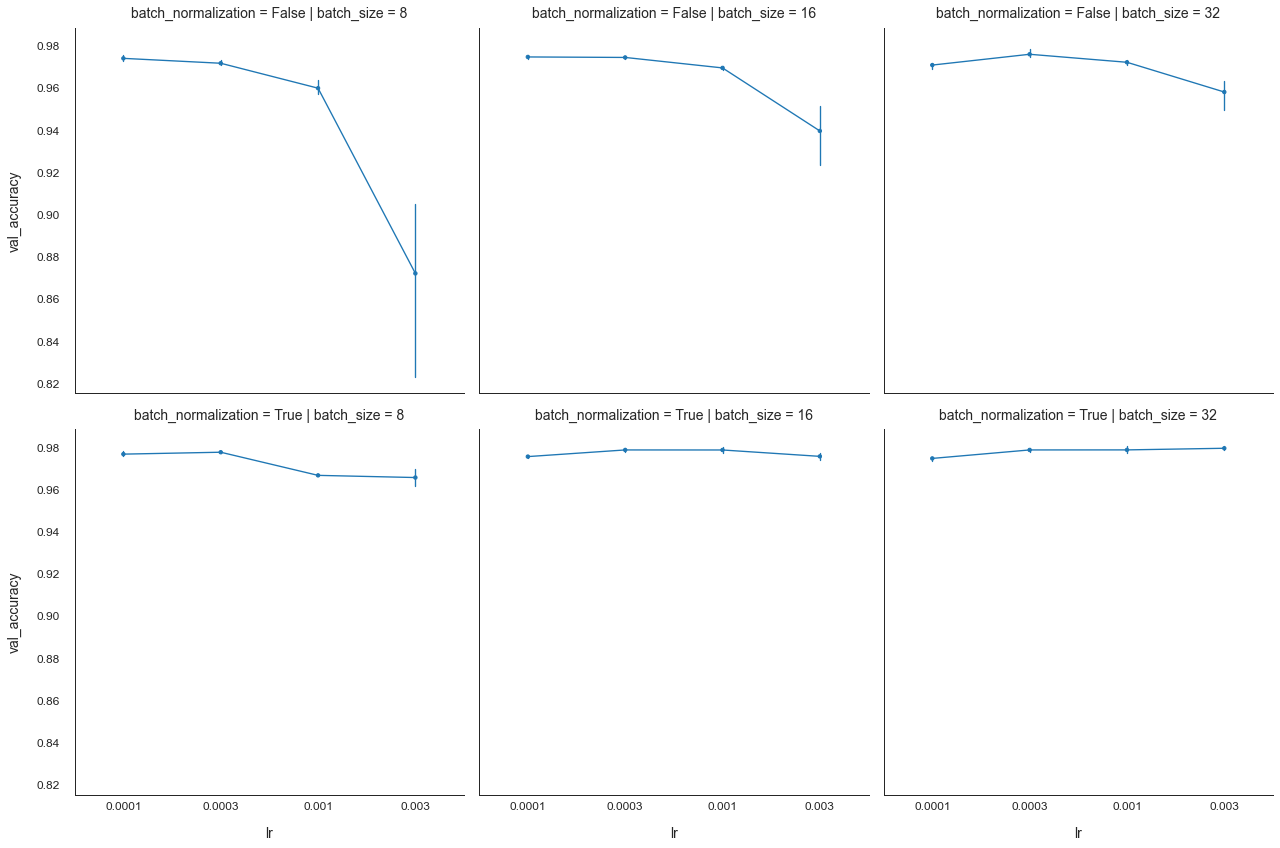

In [111]:
# Plot experiment results 
sns.set_style("ticks")
sns.set_palette("tab10")
fig = sns.FacetGrid(exp_data, col = 'batch_size', row='batch_normalization', height=6)
fig.map(sns.pointplot,'lr','val_accuracy')

When batch normalization is included larger learning rates do not lead to divergence. When it is missing problem appear most significant when using small batch size. Results indicate it would be reasonalbe to investigate even larger batch sizes. However running another scan would take long time and probably simple convolutional network will work better anyway. 

In [119]:
# Save best model to file
talos.Deploy(scan_object=scan_object, model_name='mnist_model', metric='val_accuracy')

Deploy package mnist_model have been saved.


In [120]:
# load model from file
best_model = talos.Restore('mnist_model.zip')

In [142]:
best_model.model.compile(optimizer=Adam(learning_rate=0.0030), 
                         loss='categorical_crossentropy', 
                         metrics=['accuracy'])
best_model.model.fit(X_train_tr, y_train, 
                     validation_data = [X_valid_tr, y_valid], 
                        batch_size = 32, 
                        callbacks = [early_stopping_cb, tf.keras.callbacks.TensorBoard(get_run_logdir())], 
                        epochs = 100,
                        verbose = 0
                        )

313/313 [==============================] - 1s 2ms/step


<AxesSubplot:>

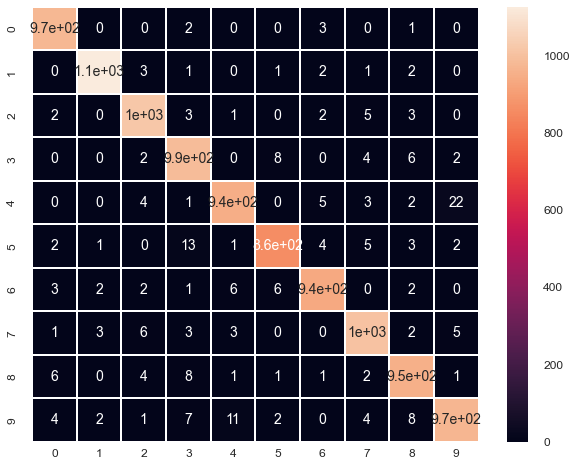

In [159]:
# create confusion matrix
predictions = best_model.model.predict(X_test_tr)
conf_matrix = tf.math.confusion_matrix(labels=tf.argmax(y_test, axis=1), predictions=tf.argmax(predictions, axis=1))
# plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, linecolor="white", linewidths=2)

Main type of errors are betweenp airs 5-3 and 9-4. 

In [164]:
# evaluate model on test set
test_results = best_model.model.evaluate(X_test_tr, y_test, verbose=0)
print("Testing accuracy of model is {} and loss is {}".format(round(test_results[1], 3), round(test_results[0], 3)))

Testing accuracy of model is 0.977 and loss is 0.089
